# Recreating the previous meta-analysis

i.e. '[Understanding coralline algal responses to ocean acidification: Meta-analysis and synthesis](https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.15899)' (Cornwall et al., 2022)

The R code used for the analysis (Meta-analysis Figure 5-6.Rmd), along with the two .csv datasets (juvenile_raw_data(in).csv, juvenile_raw_data(in).csv) were provided by Ben Harvey.

The following is a translation of the original R code into Python to compare and contrast with our new analysis.


In [225]:
### autoreload
%reload_ext autoreload
%autoreload 2

### imports
import pandas as pd
import numpy as np
from calcification import config, analysis
import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
import matplotlib.pyplot as plt
from tqdm import tqdm

# R
metafor = rpackages.importr("metafor")
base = rpackages.importr("base")
mumin = rpackages.importr("MuMIn")
pandas2ri.activate()    # ensure pandas to R conversion is activated
# custom
from calcification import utils, plotting, analysis

# effects_fp = config.tmp_data_dir / "effect_sizes.csv"
# effects = pd.read_csv(effects_fp)

all_df = analysis.calculate_effect_sizes_end_to_end(
    raw_data_fp=config.data_dir / 'Orlando_data.xlsx',
    data_sheet_name='all_data',
    climatology_data_fp=config.climatology_data_dir / 'site_locations_with_MMM_and_pH.csv',
    selection_dict={'include': 'yes'},
)
save_cols = utils.read_yaml(config.resources_dir / "mapping.yaml")['save_cols']
all_df = all_df[save_cols]


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.
Loading measured values...
1: (3401, 82)
2: (7058, 66)
3: (3401, 64)
Calculating total pH values...
4: (3401, 64)
5: (3401, 64)
6: (3401, 33)


Calculating carbonate chemistry:   0%|          | 0/3401 [00:00<?, ?it/s]

7: (3401, 33)

Shape of dataframe with all rows marked for inclusion: (3401, 82)

Calculating effect sizes...


  0%|          | 0/152 [00:00<?, ?it/s]


Shape of dataframe with effect sizes: (1225, 112)


In [260]:
all_df = analysis.calculate_effect_sizes_end_to_end(
    raw_data_fp=config.data_dir / 'Orlando_data.xlsx',
    data_sheet_name='all_data',
    climatology_data_fp=config.climatology_data_dir / 'site_locations_with_MMM_and_pH.csv',
    selection_dict={'include': 'yes'},
)


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.
Loading measured values...
1: (3401, 82)
2: (7058, 66)
3: (3401, 64)
Calculating total pH values...
4: (3401, 64)
5: (3401, 64)
6: (3401, 33)


Calculating carbonate chemistry:   0%|          | 0/3401 [00:00<?, ?it/s]

7: (3401, 33)

Shape of dataframe with all rows marked for inclusion: (3401, 82)

Calculating effect sizes...


  0%|          | 0/152 [00:00<?, ?it/s]


Shape of dataframe with effect sizes: (1127, 112)


(np.float64(0.1532), np.float64(9.0668))


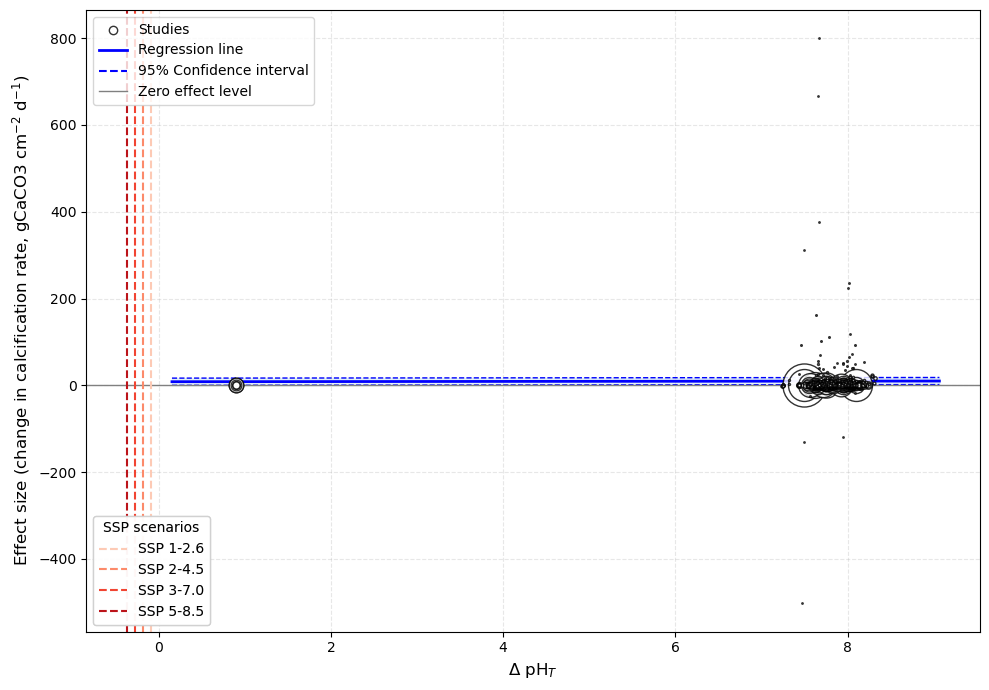

In [243]:
# Plot the meta-regression
reg_fig, reg_ax = plotting.meta_regplot(
    model=test_model,
    mod_pos=0,
    pi=False,
    xlab="$\\Delta$ pH$_T$",
    ylab="Effect size (change in calcification rate, gCaCO3 cm$^{-2}$ d$^{-1}$)",
    # predlim=(-1,0),
    # xlim=(-1, 0),
    # ylim=(-0.001, 0.001)
)

# Capture the original y-limits before modifying the plot
original_ylim = reg_ax.get_ylim()

import seaborn as sns
scenarios = predictions_shortform['scenario'].unique()
scenario_colours = sns.color_palette("Reds", len(scenarios))
scenario_colour_dict = {scenario: scenario_colours[i] for i, scenario in enumerate(scenarios)}

scenario_lines = []
for scenario in scenarios:
    # Add climatology lines to the plot
    predicted_effect_sizes = predictions_shortform[
        (predictions_shortform['scenario_var'] == 'ph') & 
        (predictions_shortform['time_frame'] == 2090) &
        (predictions_shortform['scenario'] == scenario)
    ][:]['anomaly_value_mean']

    # Plot vertical lines for each predicted effect size
    for effect_size in predicted_effect_sizes:
        line = reg_ax.vlines(
            x=effect_size,
            ymin=original_ylim[0],  # Use the fixed original y-axis minimum
            ymax=original_ylim[1],  # Use the fixed original y-axis maximum
            color=scenario_colour_dict[scenario],  # Optional: specify color
            linestyle='--',  # Optional: specify line style
            label=plotting.SCENARIO_MAP[scenario]  # Optional: add a label
        )
        scenario_lines.append(line)
# crop to y lim
reg_ax.set_ylim(original_ylim[0], original_ylim[1])
# TODO: add second legend for the climatology lines
# get existing legend
legend1 = reg_ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
reg_ax.add_artist(legend1)
reg_ax.add_artist(legend2)
# reg_fig

Text(0, 0.5, 'Frequency')

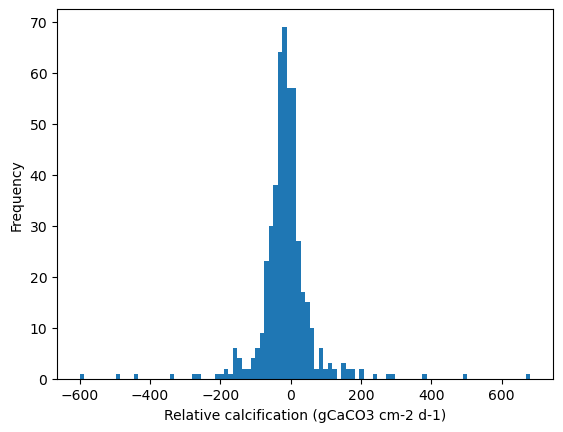

In [268]:
working_df = all_df.copy()
# # area-normalised mass only
working_df = working_df[working_df['st_calcification_unit'] == 'gCaCO3 cm-2d-1']

# plt.hist(working_df[(working_df.st_relative_calcification > -2000) & (working_df.st_relative_calcification < 2000)]['st_relative_calcification'], bins=100);
plt.hist(working_df.st_relative_calcification, bins=100);
plt.xlabel('Relative calcification (gCaCO3 cm-2 d-1)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

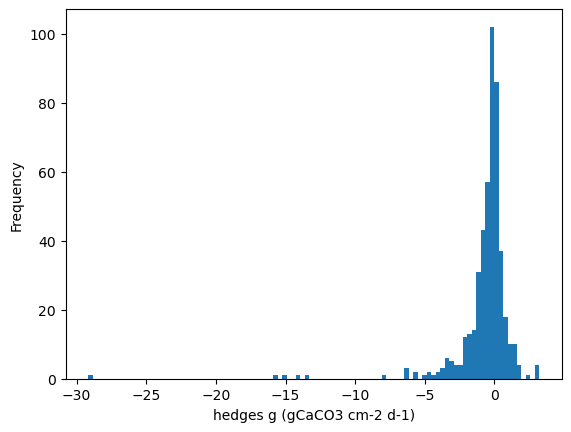

In [269]:
working_df = all_df.copy()
# # area-normalised mass only
working_df = working_df[working_df['st_calcification_unit'] == 'gCaCO3 cm-2d-1']

# plt.hist(working_df[(working_df.st_relative_calcification > -2000) & (working_df.st_relative_calcification < 2000)]['st_relative_calcification'], bins=100);
plt.hist(working_df.hedges_g, bins=100);
plt.xlabel('hedges g (gCaCO3 cm-2 d-1)')
plt.ylabel('Frequency')

In [139]:
### load climatology for predictions and contextualising
ph_climatology = utils.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

sst_climatology = utils.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

# concatenated sst and ph climatology dataframes
merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)

# set multiindex
merged_clim_df_mi = merged_clim_df.set_index(['doi', 'location', 'longitude', 'latitude'])

all_df_df_mi = all_df.set_index(['doi', 'location', 'longitude', 'latitude'])
all_df_clim_df = all_df_df_mi.join(merged_clim_df_mi, how='inner')

# length of complete all_df_df - number of rows not matching up with sst_df, multiplied by number of sst rows per effect row
expected_num = (len(all_df_df_mi) - len(set(all_df_df_mi.index).difference(set(merged_clim_df_mi.index)))) * 12
actual_num = len(all_df_clim_df)

print(f"Expected number of rows: {expected_num}")
print(f"{expected_num-actual_num}-row anomaly between climatology and all_df dataframes")
print('Number of unique locations in ', all_df_clim_df.index.nunique(), " CONCERNING") # CHECK

Expected number of rows: 13524
2892-row anomaly between climatology and all_df dataframes
Number of unique locations in  117  CONCERNING


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/utils.py:783: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/utils.py:783: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


In [270]:
working_df.treatment.value_counts()

treatment
phtot    315
temp     166
Name: count, dtype: int64

In [271]:
### preprocessing
# add ID column
working_df.loc[:,"ID"] = working_df.index
# exclude rows with st_calcifcation_unit nan
working_df = working_df[~working_df['st_treatment_calcification'].isna()]
working_df = working_df[~working_df['st_calcification_unit'].isna()]
working_df['st_treatment_calcification'] = pd.to_numeric(working_df.st_treatment_calcification, errors='coerce')
working_df['st_treatment_calcification_sd'] = pd.to_numeric(working_df.st_treatment_calcification_sd, errors='coerce')

In [272]:
ph_model, ph_model_summary, ph_df = analysis.run_metafor_model(
    working_df,
    effect_type='hedges_g',
    # effect_type_var = 'st_calcification_sd',
    treatment='phtot',
    necessary_vars=['temp', 'core_grouping'],
)

temp_model, temp_model_summary, temp_df = analysis.run_metafor_model(
    working_df,
    effect_type='hedges_g',
    # effect_type_var = 'st_calcification_sd',
    treatment='temp',
    necessary_vars=['phtot', 'core_grouping'],
)


----- PROCESSING SUMMARY -----
Treatment:  phtot
Total samples in input data:  481
Total samples of relevant investigation:  315
Dropped due to NaN values in required columns: 29
Final sample count: 286 (195 rows dropped)

Removed 3 outlier(s) (from 286 samples) based on Cook's distance threshold of 0.24
Using formula hedges_g ~ temp + delta_ph + factor(core_grouping) - 1

Running metafor model...


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "duration". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "loc". Fall back to string conversion. The error is: <class 'tuple'>

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "methods". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() 

Model fitting complete.

----- PROCESSING SUMMARY -----
Treatment:  temp
Total samples in input data:  481
Total samples of relevant investigation:  166
Dropped due to NaN values in required columns: 37
Final sample count: 129 (352 rows dropped)

Removed 2 outlier(s) (from 129 samples) based on Cook's distance threshold of 0.36
Using formula hedges_g ~ phtot + delta_t + factor(core_grouping) - 1

Running metafor model...
Model fitting complete.


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "duration". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "loc". Fall back to string conversion. The error is: <class 'tuple'>

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "methods". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() 

In [274]:
all_df.delta_t

0       2.30
1       2.30
2       0.10
3       0.10
4       2.30
        ... 
1122    0.05
1123    1.97
1124    2.00
1125    0.02
1126    0.05
Name: delta_t, Length: 1127, dtype: float64

(np.float64(-0.9693744150903683), np.float64(-0.01004024699133338))


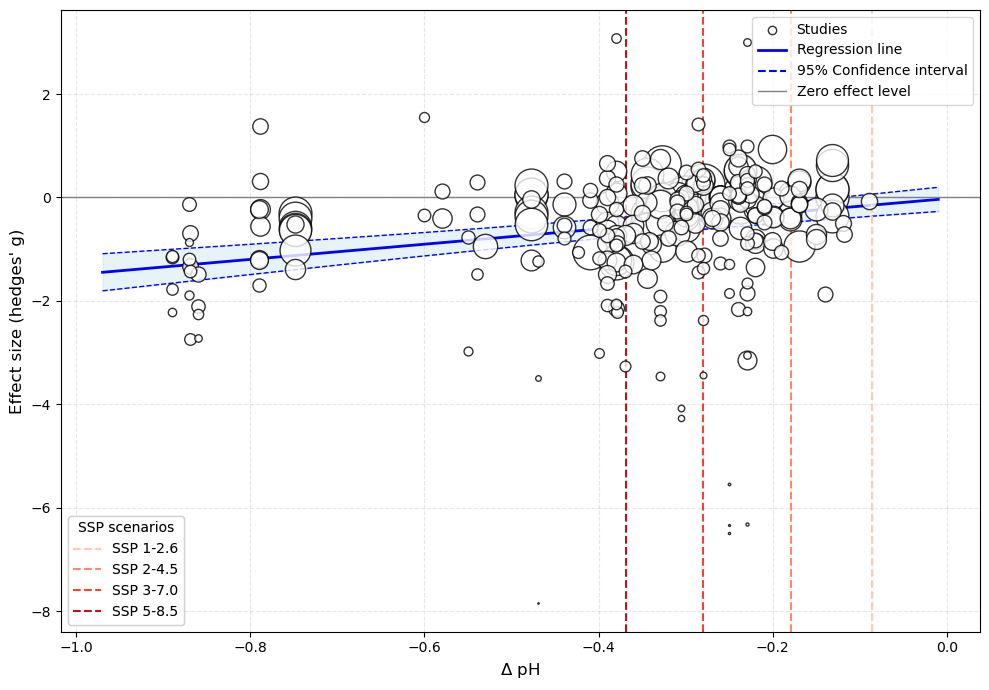

In [277]:
# Plot the meta-regression
reg_fig, reg_ax = plotting.meta_regplot(
    model=ph_model,
    mod_pos=1,
    pi=False,
    xlab="$\\Delta$ pH",
    ylab="Effect size (hedges' g)",
)

# Capture the original y-limits before modifying the plot
original_ylim = reg_ax.get_ylim()

import seaborn as sns
scenarios = predictions_shortform['scenario'].unique()
scenario_colours = sns.color_palette("Reds", len(scenarios))
scenario_colour_dict = {scenario: scenario_colours[i] for i, scenario in enumerate(scenarios)}

scenario_lines = []
for scenario in scenarios:
    # Add climatology lines to the plot
    predicted_effect_sizes = predictions_shortform[
        (predictions_shortform['scenario_var'] == 'ph') & 
        (predictions_shortform['time_frame'] == 2090) &
        (predictions_shortform['scenario'] == scenario)
    ][:]['anomaly_value_mean']

    # Plot vertical lines for each predicted effect size
    for effect_size in predicted_effect_sizes:
        line = reg_ax.vlines(
            x=effect_size,
            ymin=original_ylim[0],  # Use the fixed original y-axis minimum
            ymax=original_ylim[1],  # Use the fixed original y-axis maximum
            color=scenario_colour_dict[scenario],  # Optional: specify color
            linestyle='--',  # Optional: specify line style
            label=plotting.SCENARIO_MAP[scenario]  # Optional: add a label
        )
        scenario_lines.append(line)
# crop to y lim
reg_ax.set_ylim(original_ylim[0], original_ylim[1])
# TODO: add second legend for the climatology lines
# get existing legend
legend1 = reg_ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
reg_ax.add_artist(legend1)
reg_ax.add_artist(legend2)
# reg_fig

(np.float64(-0.560000000000003), np.float64(9.759999999999998))


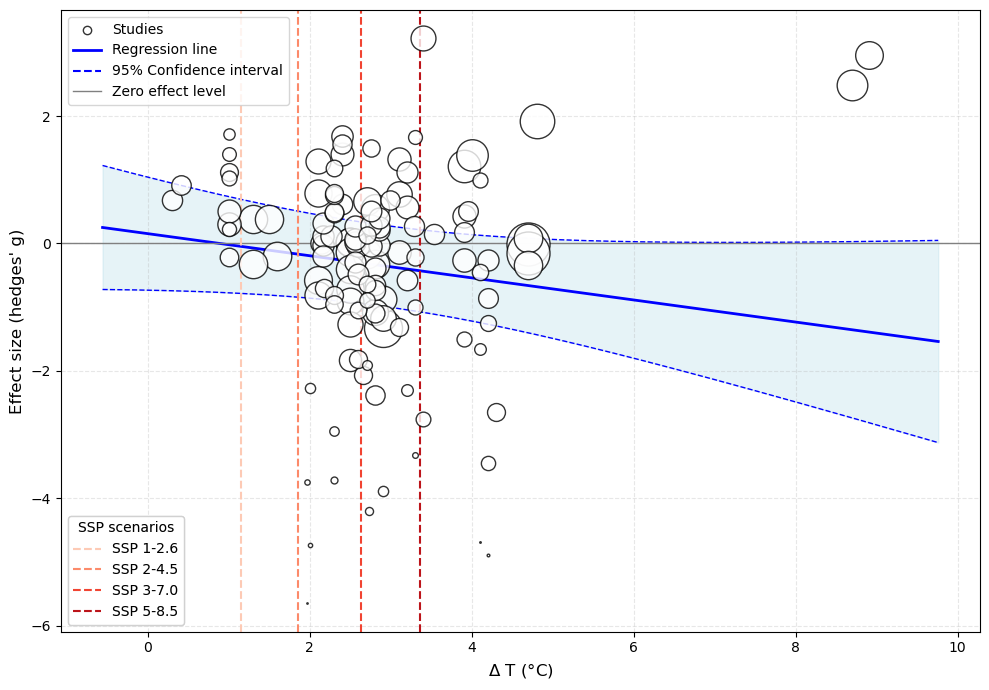

In [276]:
# Plot the meta-regression
reg_fig, reg_ax = plotting.meta_regplot(
    model=temp_model,
    mod_pos=1,
    pi=False,
    xlab="$\\Delta$ T (°C)",
    ylab="Effect size (hedges' g)",
    # predlim=(0,10),
    # xlim=(0,10),
#     colorby=working_df['extractor']
)

# Capture the original y-limits before modifying the plot
original_ylim = reg_ax.get_ylim()

import seaborn as sns
scenarios = predictions_shortform['scenario'].unique()
scenario_colours = sns.color_palette("Reds", len(scenarios))
scenario_colour_dict = {scenario: scenario_colours[i] for i, scenario in enumerate(scenarios)}

scenario_lines = []
for scenario in scenarios:
    # Add climatology lines to the plot
    predicted_effect_sizes = predictions_shortform[
        (predictions_shortform['scenario_var'] == 'sst') & 
        (predictions_shortform['time_frame'] == 2090) &
        (predictions_shortform['scenario'] == scenario)
    ][:]['anomaly_value_mean']

    # Plot vertical lines for each predicted effect size
    for effect_size in predicted_effect_sizes:
        line = reg_ax.vlines(
            x=effect_size,
            ymin=original_ylim[0],  # Use the fixed original y-axis minimum
            ymax=original_ylim[1],  # Use the fixed original y-axis maximum
            color=scenario_colour_dict[scenario],  # Optional: specify color
            linestyle='--',  # Optional: specify line style
            label=plotting.SCENARIO_MAP[scenario]  # Optional: add a label
        )
        scenario_lines.append(line)
# crop to y lim
reg_ax.set_ylim(original_ylim[0], original_ylim[1])
# TODO: add second legend for the climatology lines
# get existing legend
legend1 = reg_ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
reg_ax.add_artist(legend1)
reg_ax.add_artist(legend2)
# reg_fig

In [247]:
ph_model, ph_model_summary, ph_df = analysis.run_metafor_model(
    working_df,
    effect_type='st_absolute_calcification',
    # effect_type_var = 'st_calcification_sd',
    treatment='phtot',
    necessary_vars=['temp', 'core_grouping'],
)

temp_model, temp_model_summary, temp_df = analysis.run_metafor_model(
    working_df,
    effect_type='st_absolute_calcification',
    # effect_type_var = 'st_calcification_sd',
    treatment='temp',
    necessary_vars=['phtot', 'core_grouping'],
)


----- PROCESSING SUMMARY -----
Treatment:  phtot
Total samples in input data:  546
Total samples of relevant investigation:  339
Dropped due to NaN values in required columns: 70
Final sample count: 269 (277 rows dropped)

Removed 1 outlier(s) (from 269 samples) based on Cook's distance threshold of 0.25
Using formula st_absolute_calcification ~ temp + delta_ph + factor(core_grouping) - 1

Running metafor model...
Model fitting complete.

----- PROCESSING SUMMARY -----
Treatment:  temp
Total samples in input data:  546
Total samples of relevant investigation:  207
Dropped due to NaN values in required columns: 78
Final sample count: 129 (417 rows dropped)

Removed 3 outlier(s) (from 129 samples) based on Cook's distance threshold of 0.36
Using formula st_absolute_calcification ~ phtot + delta_t + factor(core_grouping) - 1

Running metafor model...
Model fitting complete.


In [249]:
print(temp_model_summary)


Multivariate Meta-Analysis Model (k = 126; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
  750.5251  -1501.0502  -1487.0502  -1467.4797  -1486.0590   

Variance Components:

            estim    sqrt  nlvls  fixed           factor 
sigma^2.1  0.0000  0.0003     17     no     original_doi 
sigma^2.2  0.0000  0.0004    126     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 121) = 1075.0894, p-val < .0001

Test of Moderators (coefficients 1:5):
QM(df = 5) = 7.2423, p-val = 0.2032

Model Results:

                                  estimate      se     zval    pval    ci.lb 
phtot                              -0.0001  0.0002  -0.4088  0.6827  -0.0004 
delta_t                            -0.0000  0.0000  -0.9568  0.3387  -0.0001 
factor(core_grouping)CCA            0.0005  0.0013   0.3925  0.6947  -0.0021 
factor(core_grouping)Coral          0.0006  0.0013   0.4435  0.6574  -0.0020 
factor(core_grouping)Other algae   -0.0001  0.0013  -0.1015  0.

In [213]:
sst_all = pd.DataFrame(analysis.generate_location_specific_predictions(
    model=temp_model,
    df=all_df_clim_df,
    scenario_var='sst'
))
sst_preds = sst_all.groupby(['scenario', 'time_frame', 'percentile'])[['anomaly_value', 'predicted_effect_size']].mean().reset_index()
sst_preds_shortform = sst_preds.pivot(index=['scenario', 'time_frame'], columns='percentile', values=['anomaly_value', 'predicted_effect_size'])
sst_preds_shortform.columns = ['_'.join(col).strip() for col in sst_preds_shortform.columns.values]
sst_preds_shortform.reset_index(inplace=True)
# sst_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)

ph_all = pd.DataFrame(analysis.generate_location_specific_predictions(
    model=ph_model,
    df=all_df_clim_df,
    scenario_var='ph'
))
ph_preds = ph_all.groupby(['scenario', 'time_frame', 'percentile'])[['anomaly_value', 'predicted_effect_size']].mean().reset_index()
ph_preds_shortform = ph_preds.pivot(index=['scenario', 'time_frame'], columns='percentile', values=['anomaly_value', 'predicted_effect_size'])
ph_preds_shortform.columns = ['_'.join(col).strip() for col in ph_preds_shortform.columns.values]
ph_preds_shortform.reset_index(inplace=True)
# ph_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)
ph_preds_shortform['scenario_var'] = 'ph'
sst_preds_shortform['scenario_var'] = 'sst'

predictions_shortform = pd.concat([sst_preds_shortform, ph_preds_shortform], axis=0)
spatial_predictions = pd.concat([sst_all, ph_all], axis=0)  # currently only for sst: TODO: for ph

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Ratio of largest to smallest sampling variance extremely large. May not be able to obtain stable results. 

R[write to console]: 2: Ratio of largest to smallest sampling variance extremely large. May not be able to obtain stable results. 

R[write to console]: 3: Extra argument ('useS4') disregarded. 



Generating batched predictions for sst:   0%|          | 0/117 [00:00<?, ?it/s]

Generating batched predictions for ph:   0%|          | 0/117 [00:00<?, ?it/s]

## Regression plots

(-1, 0)


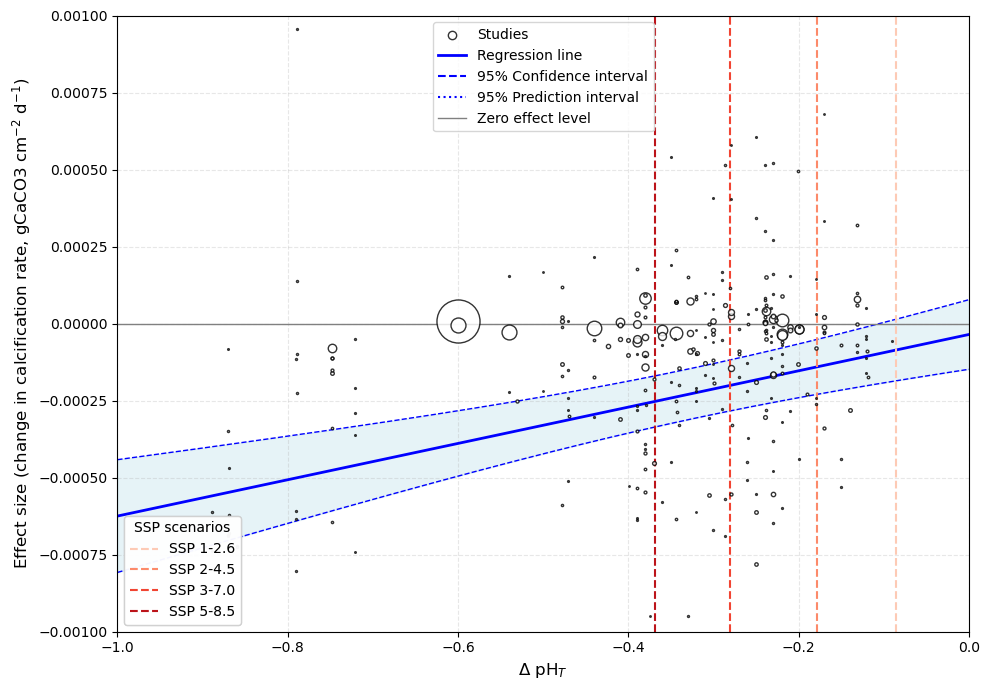

In [217]:
# Plot the meta-regression
reg_fig, reg_ax = plotting.meta_regplot(
    model=ph_model,
    mod_pos=0,
    pi=False,
    xlab="$\\Delta$ pH$_T$",
    ylab="Effect size (change in calcification rate, gCaCO3 cm$^{-2}$ d$^{-1}$)",
    predlim=(-1,0),
    xlim=(-1, 0),
    ylim=(-0.001, 0.001)
)

# Capture the original y-limits before modifying the plot
original_ylim = reg_ax.get_ylim()

import seaborn as sns
scenarios = predictions_shortform['scenario'].unique()
scenario_colours = sns.color_palette("Reds", len(scenarios))
scenario_colour_dict = {scenario: scenario_colours[i] for i, scenario in enumerate(scenarios)}

scenario_lines = []
for scenario in scenarios:
    # Add climatology lines to the plot
    predicted_effect_sizes = predictions_shortform[
        (predictions_shortform['scenario_var'] == 'ph') & 
        (predictions_shortform['time_frame'] == 2090) &
        (predictions_shortform['scenario'] == scenario)
    ][:]['anomaly_value_mean']

    # Plot vertical lines for each predicted effect size
    for effect_size in predicted_effect_sizes:
        line = reg_ax.vlines(
            x=effect_size,
            ymin=original_ylim[0],  # Use the fixed original y-axis minimum
            ymax=original_ylim[1],  # Use the fixed original y-axis maximum
            color=scenario_colour_dict[scenario],  # Optional: specify color
            linestyle='--',  # Optional: specify line style
            label=plotting.SCENARIO_MAP[scenario]  # Optional: add a label
        )
        scenario_lines.append(line)
# crop to y lim
reg_ax.set_ylim(original_ylim[0], original_ylim[1])
# TODO: add second legend for the climatology lines
# get existing legend
legend1 = reg_ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
reg_ax.add_artist(legend1)
reg_ax.add_artist(legend2)
# reg_fig

(0, 10)


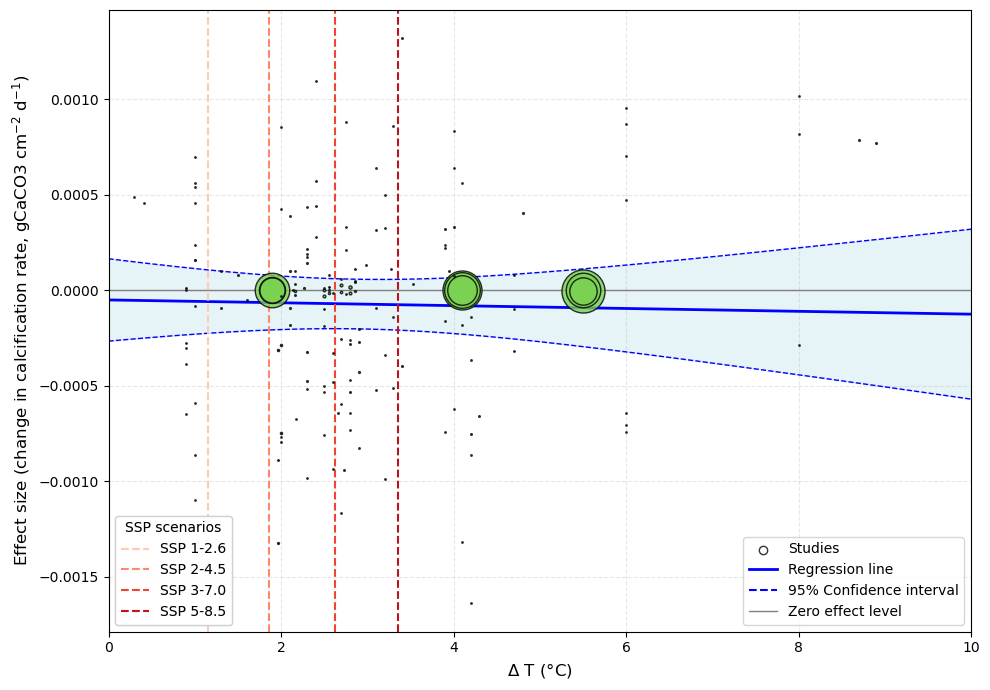

In [219]:
# Plot the meta-regression
reg_fig, reg_ax = plotting.meta_regplot(
    model=temp_model,
    mod_pos=0,
    pi=False,
    xlab="$\\Delta$ T (°C)",
    ylab="Effect size (change in calcification rate, gCaCO3 cm$^{-2}$ d$^{-1}$)",
    predlim=(0,10),
    xlim=(0,10),
    colorby=working_df['extractor']
)

# Capture the original y-limits before modifying the plot
original_ylim = reg_ax.get_ylim()

import seaborn as sns
scenarios = predictions_shortform['scenario'].unique()
scenario_colours = sns.color_palette("Reds", len(scenarios))
scenario_colour_dict = {scenario: scenario_colours[i] for i, scenario in enumerate(scenarios)}

scenario_lines = []
for scenario in scenarios:
    # Add climatology lines to the plot
    predicted_effect_sizes = predictions_shortform[
        (predictions_shortform['scenario_var'] == 'sst') & 
        (predictions_shortform['time_frame'] == 2090) &
        (predictions_shortform['scenario'] == scenario)
    ][:]['anomaly_value_mean']

    # Plot vertical lines for each predicted effect size
    for effect_size in predicted_effect_sizes:
        line = reg_ax.vlines(
            x=effect_size,
            ymin=original_ylim[0],  # Use the fixed original y-axis minimum
            ymax=original_ylim[1],  # Use the fixed original y-axis maximum
            color=scenario_colour_dict[scenario],  # Optional: specify color
            linestyle='--',  # Optional: specify line style
            label=plotting.SCENARIO_MAP[scenario]  # Optional: add a label
        )
        scenario_lines.append(line)
# crop to y lim
reg_ax.set_ylim(original_ylim[0], original_ylim[1])
# TODO: add second legend for the climatology lines
# get existing legend
legend1 = reg_ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
reg_ax.add_artist(legend1)
reg_ax.add_artist(legend2)
# reg_fig

In [ ]:
# Generate the interactive plot
fig = plotting.meta_regplot_plotly(
    model=ph_model, 
    mod_pos=0,  # Position of the moderator
    doi_list=working_df.doi,  # List of DOIs for coloring and hover info
    pi=False,
    xlab="$\\Delta$ T (°C)", 
    ylab="Relative calcification rate (gCaCO3 cm$^{-2}$ d$^{-1}$)",
    title="Interactive Meta-Regression Plot",
    point_size="seinv",
    ylim=(-0.005, 0.001),
)

# Display the plot
fig.show()

## Timeseries plots

In [245]:
print(ph_model_summary)


Multivariate Meta-Analysis Model (k = 300; method: REML)

    logLik    Deviance         AIC         BIC        AICc   
 1874.6334  -3749.2667  -3735.2667  -3709.4579  -3734.8765   

Variance Components:

            estim    sqrt  nlvls  fixed           factor 
sigma^2.1  0.0000  0.0002     40     no     original_doi 
sigma^2.2  0.0000  0.0003    300     no  original_doi/ID 

Test for Residual Heterogeneity:
QE(df = 295) = 3755.1532, p-val < .0001

Test of Moderators (coefficients 1:5):
QM(df = 5) = 59.9319, p-val < .0001

Model Results:

                                  estimate      se     zval    pval    ci.lb 
delta_ph                            0.0006  0.0001   4.7932  <.0001   0.0003 
factor(core_grouping)CCA            0.0001  0.0001   1.4332  0.1518  -0.0000 
factor(core_grouping)Coral         -0.0001  0.0001  -1.2245  0.2207  -0.0002 
factor(core_grouping)Halimeda      -0.0019  0.0012  -1.6656  0.0958  -0.0042 
factor(core_grouping)Other algae    0.0001  0.0002   0.2599  0.

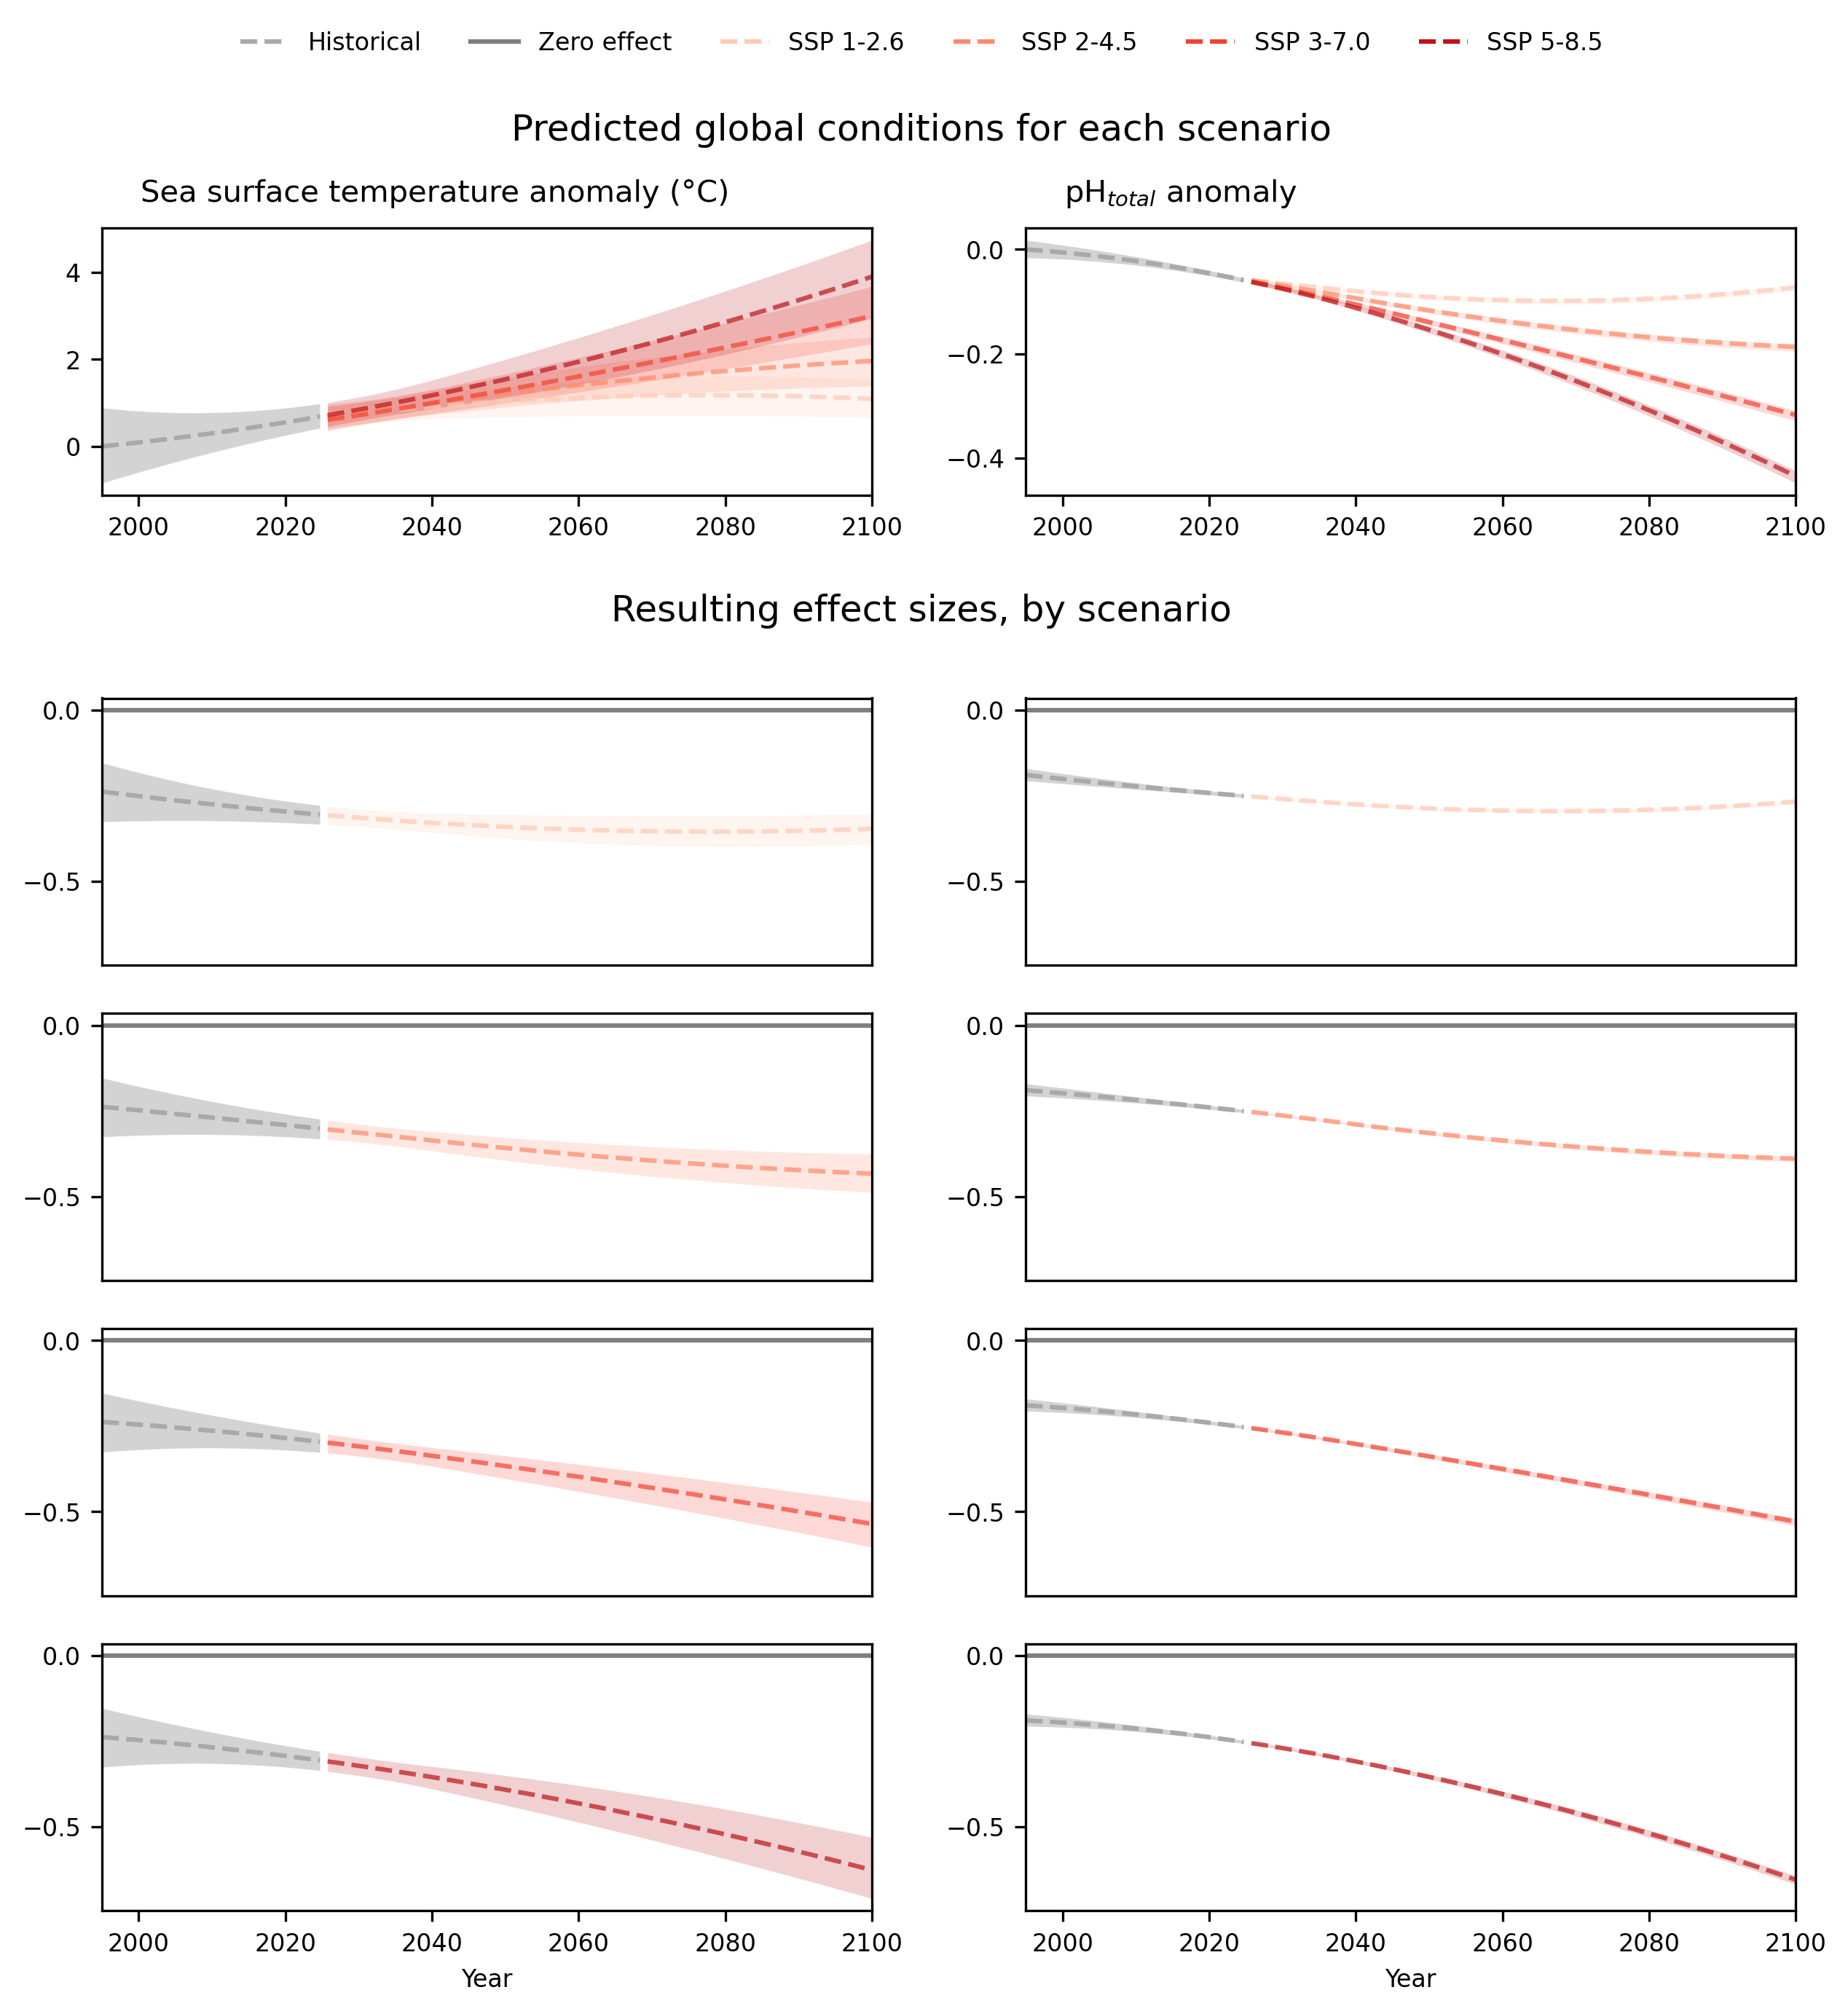

Saving figure to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures
Figure saved to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures/global_timeseries_test_2025-04-09--22-44-55.png


In [96]:
ts_fig,_ = plotting.plot_global_timeseries(predictions_shortform, plot_vars=['sst', 'ph'], figsize=(10, 10), dpi=300)
plotting.save_fig(
    fig=ts_fig,
    fig_name='global_timeseries',
    run_key='test'
)

## Spatial plots

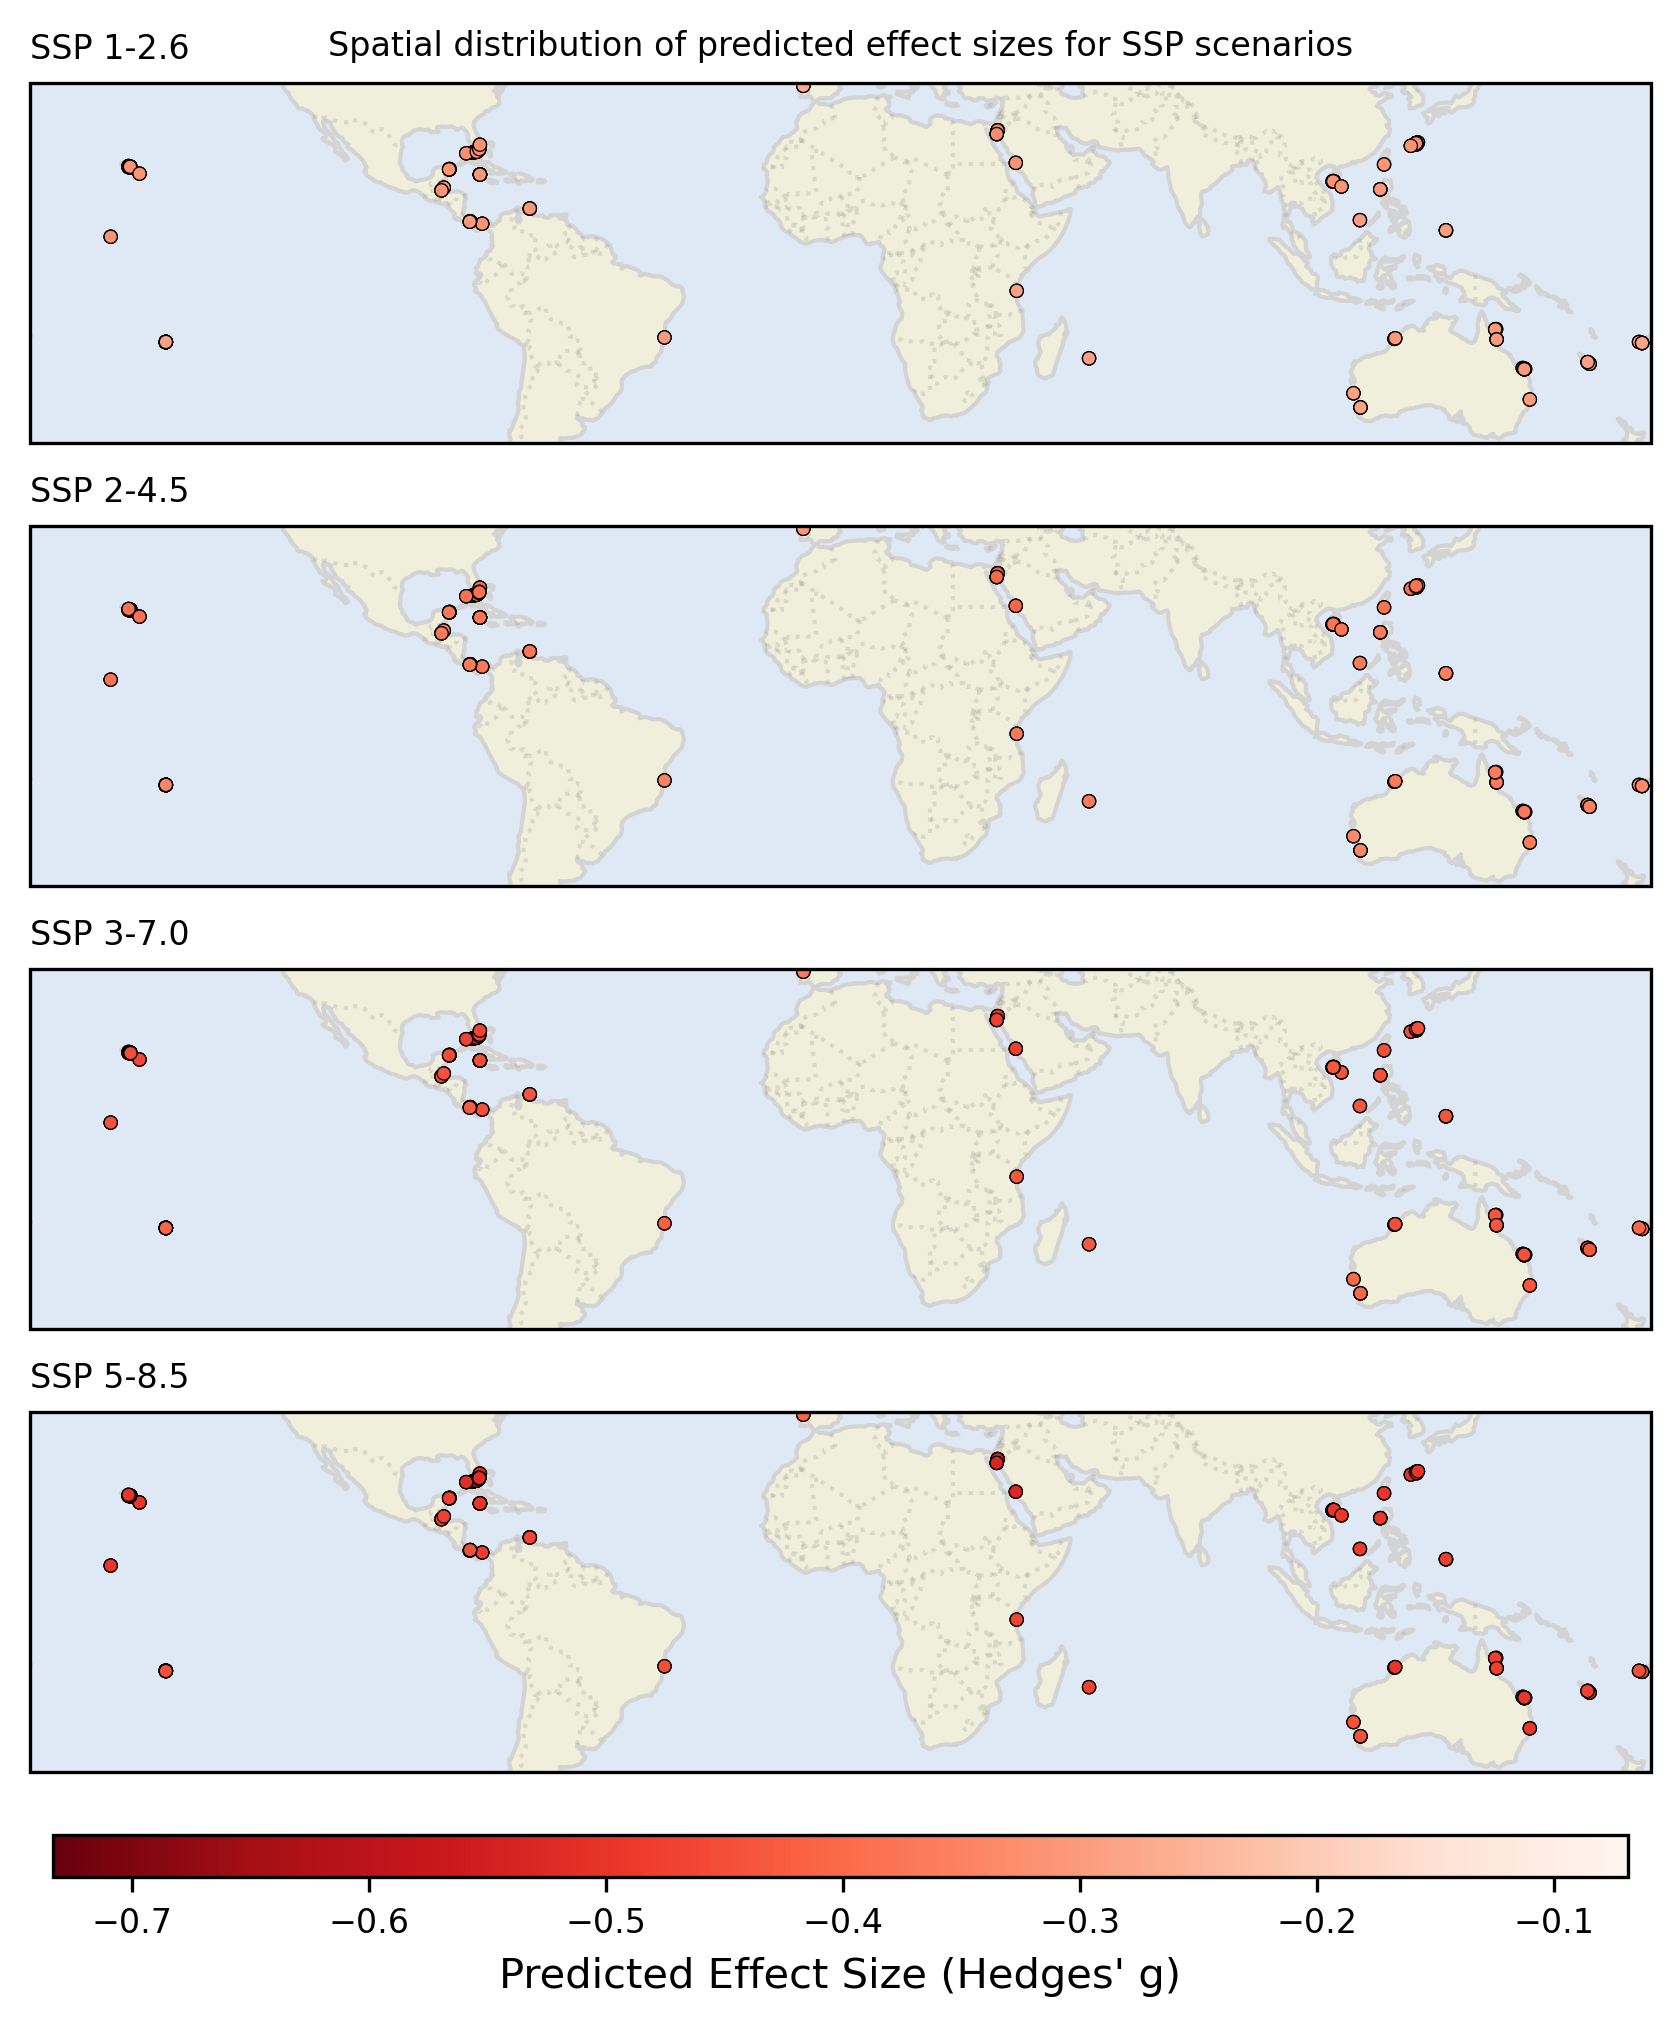

Saving figure to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures
Figure saved to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures/spatial_effect_distribution_sst_test_2025-04-09--22-45-02.png


In [97]:
spatial_predictions_sst = spatial_predictions[spatial_predictions['scenario_var'] == 'sst']
spatial_fig_sst,_ = plotting.plot_spatial_effect_distribution(spatial_predictions_sst, time_frame=2090, figsize=(7, 7), dpi=300)
plotting.save_fig(
    fig=spatial_fig_sst,
    fig_name='spatial_effect_distribution_sst',
    run_key='test'
)

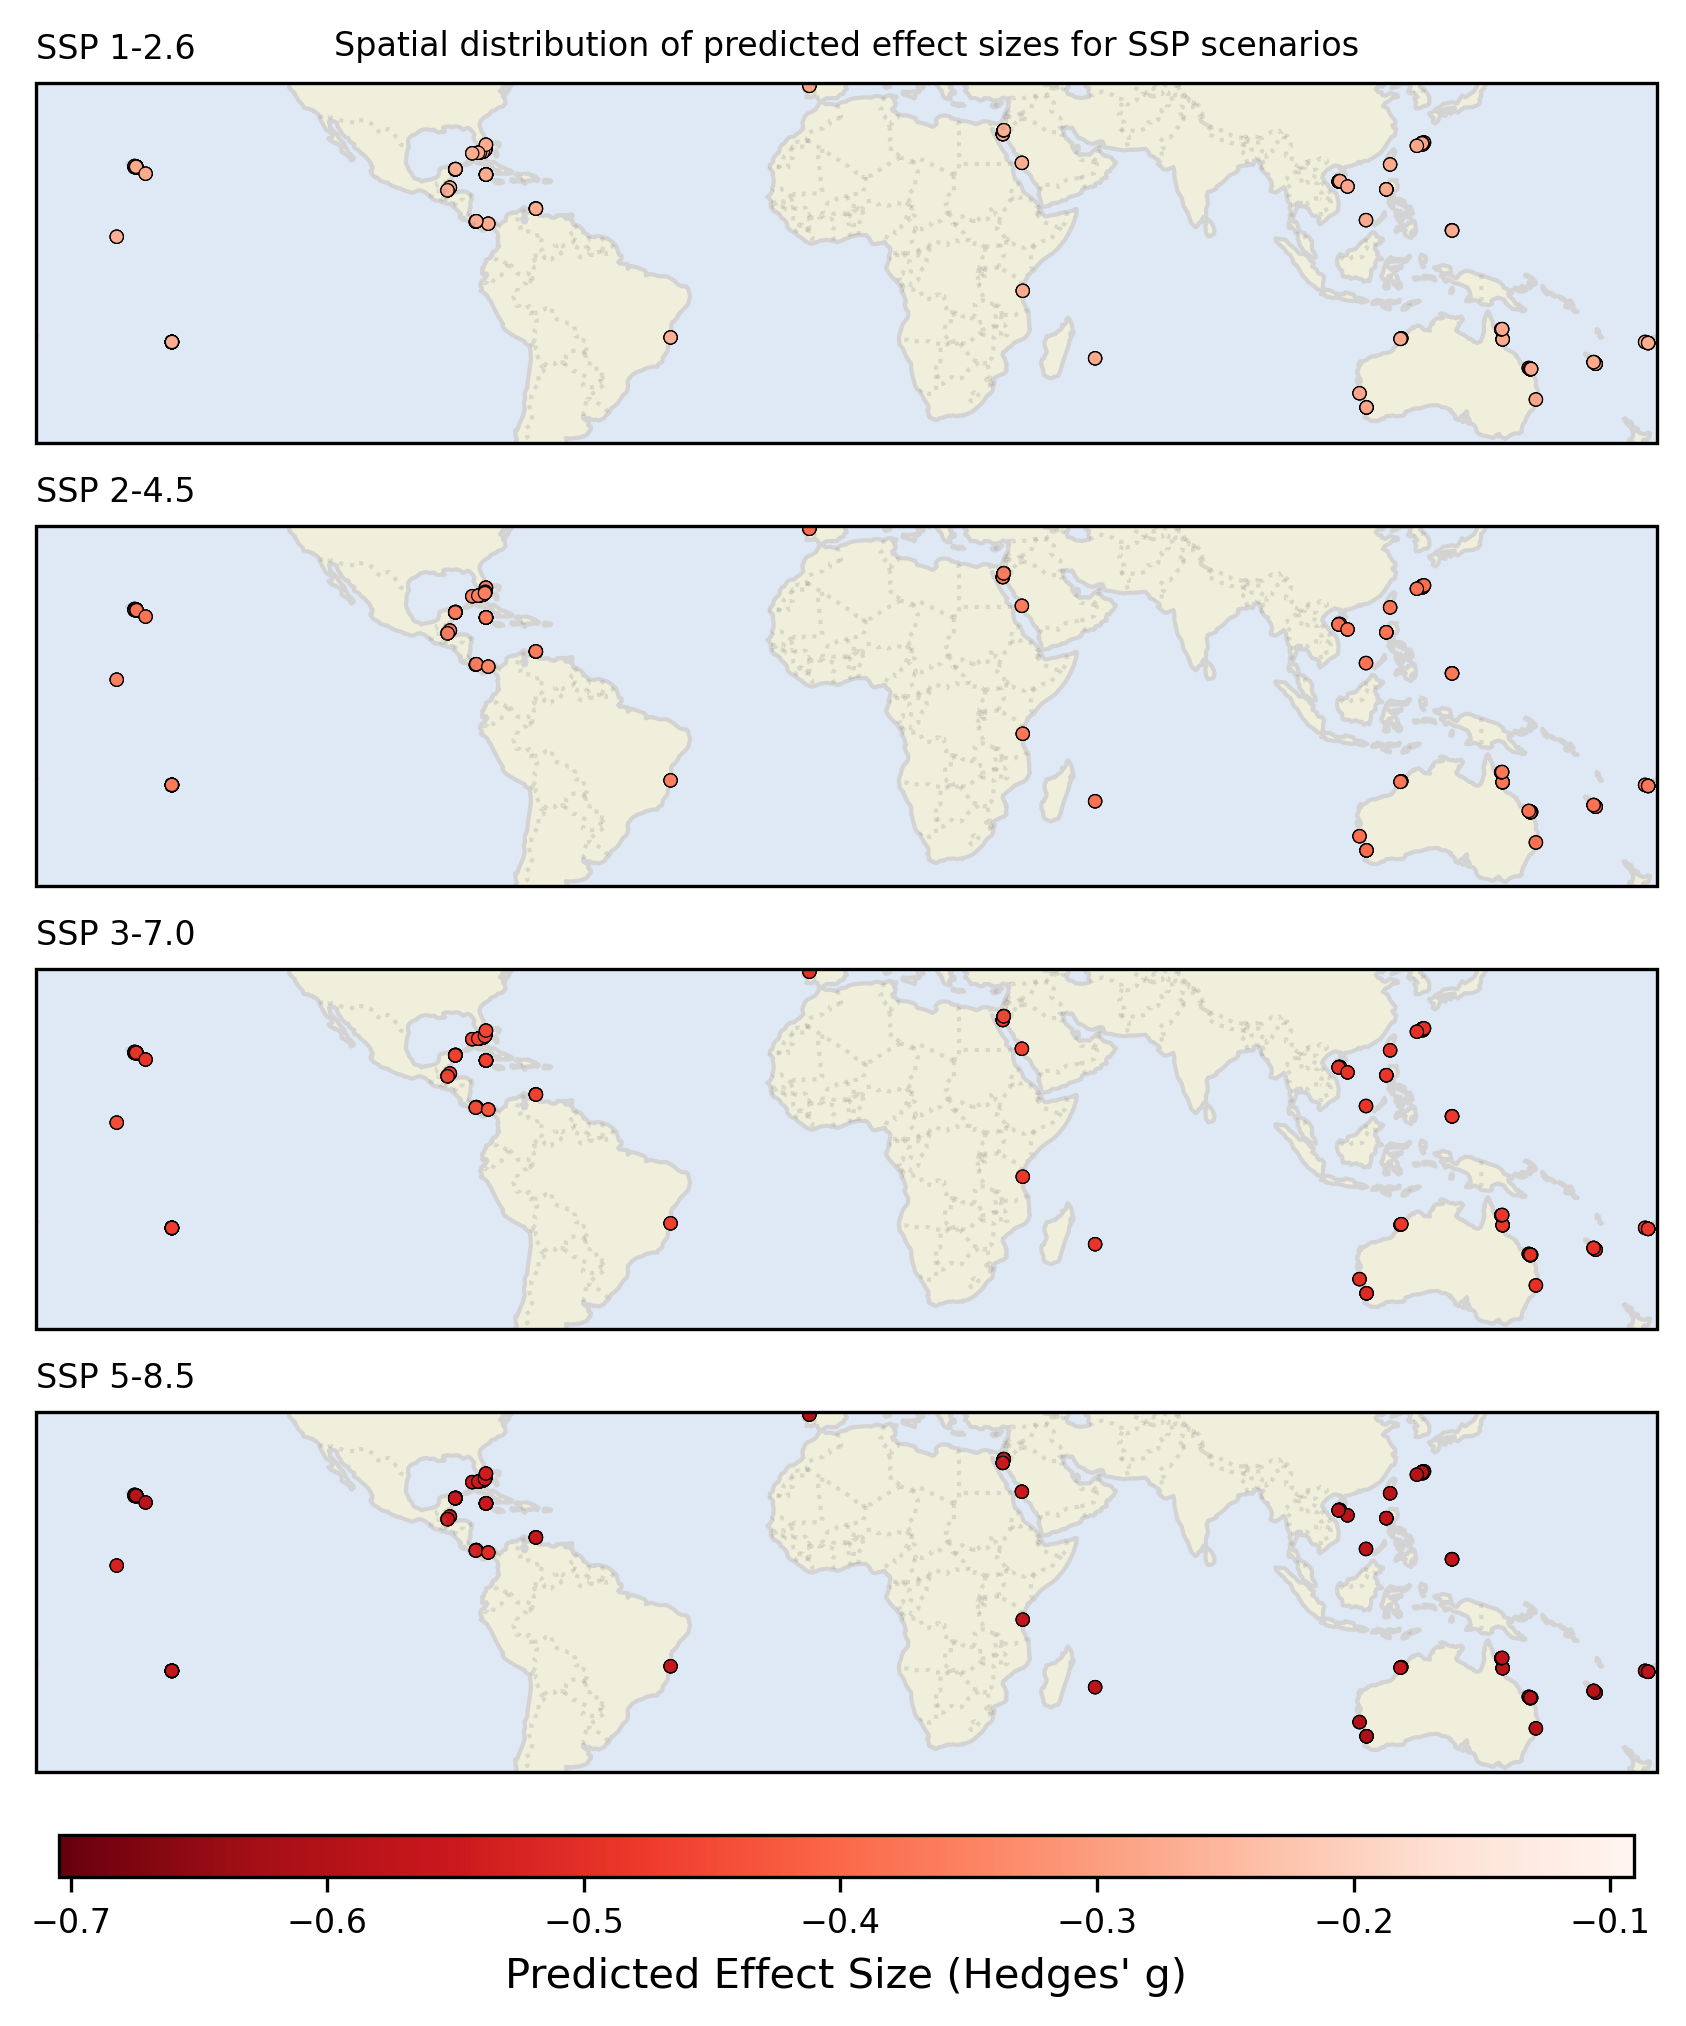

NameError: name 'spatial_fig' is not defined

In [100]:
spatial_predictions_ph = spatial_predictions[spatial_predictions['scenario_var'] == 'ph']
spatial_fig_ph, _ = plotting.plot_spatial_effect_distribution(spatial_predictions_ph, time_frame=2090, figsize=(7, 7), dpi=300)
plotting.save_fig(
    fig=spatial_fig,
    fig_name='spatial_effect_distribution_ph',
    run_key='test'
)

Removed 12 outliers (from 840 samples) based on Cook's distance threshold of 0.14


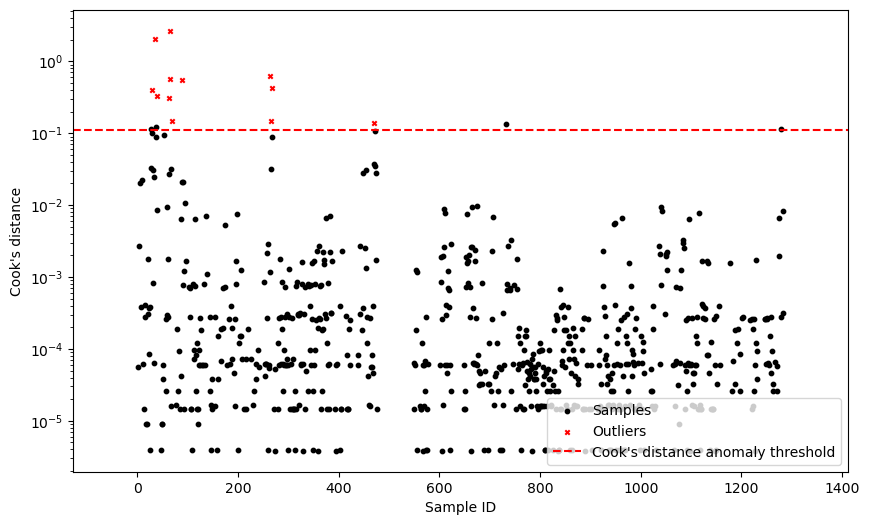

In [41]:
### visualise cooks distance
import matplotlib.pyplot as plt
import seaborn as sns

cooks_threshold = analysis.calc_cooks_threshold(working_df["hedges_g"], nparams=3)
data_no_outliers, outliers = remove_cooks_outliers(data, 'hedges_g')

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_no_outliers.index, data_no_outliers["cooks_d"], s=10, color="black", label="Samples")
# plot outliers as red dots
ax.scatter(
    outliers.ID,
    outliers.cooks_d,
    color="red",
    marker="x",
    s=10, label="Outliers",
)

ax.hlines(
    cooks_threshold,
    xmin=-working_df.ID.max()*.1,
    xmax=working_df.ID.max()*1.1,
    color="red",
    linestyle="--",
    label="Cook's distance anomaly threshold",
)
ax.set_xlim(
    -working_df.ID.max() * 0.1,
    working_df.ID.max() * 1.1,
)
ax.set_xlabel("Sample ID")
ax.set_ylabel("Cook's distance")
ax.set_yscale("log")
ax.legend(loc='lower right');

## Training model based on MuMIn

Investigating the effect of core_groupings, families, T, pH, ecoregion


In [44]:
temp_df[['hedges_g', 'hedges_g_var', 'delta_t', 'temp', 'ecoregion', 'original_doi', 'ID']].isna().any()

hedges_g        False
hedges_g_var    False
delta_t         False
temp            False
ecoregion       False
original_doi    False
ID              False
dtype: bool

In [86]:
temp_df.to_csv(
    config.tmp_data_dir / "temp_df.csv",
    index=False
)

In [ ]:
effect_type = 'hedges_g'
x_var = 'delta_t'
# global_formula = f"{effect_type} ~ {x_var} + temp + phtot + factor(family) + factor(ecoregion) + factor(realm) + factor(core_grouping) - 1"
# global_formula = f"{effect_type} ~ {x_var} + temp + factor(ecoregion) - 1"
global_formula = f"{effect_type} ~ {x_var} + temp"
r_formula = ro.Formula(global_formula)

temp_formula, temp_df = analysis.preprocess_df_for_meta_model(working_df, treatment='temp', necessary_vars=['temp', 'delta_t'])
df_r = ro.pandas2ri.py2rpy(temp_df)

global_model = metafor.rma_mv(
    yi = ro.FloatVector(df_r.rx2(effect_type)),
    V = ro.FloatVector(df_r.rx2(f"{effect_type}_var")), 
    mods = r_formula,
    random = ro.Formula("~ 1 | original_doi/ID"),
    data=df_r,
)

import os
# os.environ['LC_ALL'] = 'C'  # explicitly set locale to C (simplest)
os.environ['LC_ALL'] = 'en_US.UTF-8'  # set locale to UTF-8
ro.r.assign("global_model", global_model)

# Set up parallel processing cluster
n_cores = 16
ro.r(f"""
# set up for MuMIn
eval(metafor:::.MuMIn)
# Create cluster
clu <- parallel::makeCluster({n_cores})
# Load required packages on each worker
parallel::clusterEvalQ(clu, library(metafor))
parallel::clusterEvalQ(clu, library(MuMIn))

# Export the global model and other necessary objects to the cluster
parallel::clusterExport(clu, c("global_model"))

# # Run dredge
dredge_result <- MuMIn::dredge(global_model, cluster=clu)

# # Stop the cluster
parallel::stopCluster(clu)
""")

# """)
# ignore warnings (setting up LC_COLLATE failed, using "C")
# import warnings
# warnings.filterwarnings("ignore", category=rpy2.rinterface.RRuntimeWarning)

dredge_result = ro.r("dredge_result")
dredge_df = pandas2ri.rpy2py(dredge_result)
dredge_df = pd.DataFrame(dredge_df)
# # save to csv
# # dredge_df.to_csv(config.tmp_data_dir / "dredge_results.csv", index=False)
# # view result
dredge_df


----- PROCESSING SUMMARY -----
Total samples in input data:  1284
Total samples of relevant investigation:  444
Dropped due to NaN values in required columns: 2
Final sample count: 442 (842 rows dropped)

Removed 5 outliers (from 442 samples) based on Cook's distance threshold of 0.19


R[write to console]: Fixed term is "(Intercept)"



,(Intercept),delta_t,temp,df,logLik,AICc,delta,weight
3,1,NaN,NaN,5,-649.061924,1308.263058,0.000000,9.759244e-01
2,1,NaN,NaN,4,-653.787452,1315.667497,7.404439,2.407480e-02
1,1,NaN,NaN,4,-664.124565,1336.341723,28.078664,7.802104e-07
0,1,NaN,NaN,3,-670.211836,1346.479099,38.216040,4.908044e-09


In [71]:
ro.r("""
# Function to extract coefficients from models
get_model_coefficients <- function(ms_object) {
  coef_list <- lapply(1:nrow(ms_object), function(i) {
    model_i <- get.models(ms_object, i)[[1]]
    coefs <- coef(model_i)
    coef_df <- data.frame(
      model = i,
      variable = names(coefs),
      coefficient = unname(coefs),
      stringsAsFactors = FALSE
    )
    return(coef_df)
  })
  do.call(rbind, coef_list)
}

# Extract all coefficients
all_coefs <- get_model_coefficients(dredge_result)
write.csv(all_coefs, "model_coefficients.csv")
""")


R[write to console]: In addition: 
R[write to console]: There were 16 warnings (use warnings() to see them)
R[write to console]: 



In [79]:
ro.r("""
# Function to check if a variable is included in a model
is_variable_in_model <- function(model, variable) {
  # Get formula terms
  terms_obj <- terms(model)
  term_labels <- attr(terms_obj, "term.labels")
  
  # Check if variable is in terms
  return(variable %in% term_labels)
}

# Create a new data frame to hold results
model_table <- data.frame(
  model_id = seq_len(nrow(dredge_result)),
  df = dredge_result$df,
  logLik = dredge_result$logLik,
  AICc = dredge_result$AICc,
  delta = dredge_result$delta,
  weight = dredge_result$weight
)

# Get the actual models
models_list <- get.models(dredge_result, subset = TRUE)

# Add columns for each predictor
predictors <- c("delta_t", "temp")
for (pred in predictors) {
  model_table[[pred]] <- sapply(models_list, function(model) {
    if (is_variable_in_model(model, pred)) {
      return("INCLUDED")
    } else {
      return("EXCLUDED")
    }
  })
}

# Save to CSV
write.csv(model_table, "model_inclusion_table.csv", row.names = FALSE)

# Now get the actual coefficients
coef_table <- data.frame()
for (i in seq_along(models_list)) {
  model <- models_list[[i]]
  coefs <- coef(model)
  model_coefs <- data.frame(
    model_id = i,
    parameter = names(coefs),
    estimate = as.numeric(coefs),
    row.names = NULL
  )
  coef_table <- rbind(coef_table, model_coefs)
}

# Save coefficients
write.csv(coef_table, "model_coefficients.csv", row.names = FALSE)
""")

R[write to console]: Error in x$terms %||% attr(x, "terms") %||% stop("no terms component nor attribute") : 
  no terms component nor attribute



RRuntimeError: Error in x$terms %||% attr(x, "terms") %||% stop("no terms component nor attribute") : 
  no terms component nor attribute


In [81]:
import pandas as pd
import numpy as np

def clean_dredge_output(df):
    cleaned_df = df.copy()
    
    # Identify meta columns
    info_cols = ['df', 'logLik', 'AICc', 'delta', 'weight']
    
    # Coefficient columns (everything else)
    coef_cols = [col for col in df.columns if col not in info_cols]

    # Format coefficient columns
    for col in coef_cols:
        cleaned_df[col] = cleaned_df[col].apply(
            lambda x: f"{x:.5f}" if pd.notnull(x) else ""
        )
    
    # Round meta columns sensibly
    cleaned_df['logLik'] = cleaned_df['logLik'].round(3)
    cleaned_df['AICc'] = cleaned_df['AICc'].round(1)
    cleaned_df['delta'] = cleaned_df['delta'].round(2)
    cleaned_df['weight'] = cleaned_df['weight'].round(3)

    # Optional: add model number
    cleaned_df.insert(0, "Model", range(1, len(cleaned_df) + 1))

    return cleaned_df

cleaned_table = clean_dredge_output(dredge_df)
print(cleaned_table.head(10).to_string(index=False))


 Model (Intercept) delta_t temp  df   logLik   AICc  delta  weight
     1     1.00000                5 -649.062 1308.3   0.00   0.976
     2     1.00000                4 -653.787 1315.7   7.40   0.024
     3     1.00000                4 -664.125 1336.3  28.08   0.000
     4     1.00000                3 -670.212 1346.5  38.22   0.000


In [82]:
ro.r("""
get_dredge_summary <- function(dredge_obj) {
  result_list <- list()
  
  for (i in seq_len(nrow(dredge_obj))) {
    model_i <- get.models(dredge_obj, subset=i)[[1]]
    coefs <- summary(model_i)$beta
    vars_in_model <- names(coefs)
    all_vars <- names(dredge_obj)
    
    row <- setNames(as.list(rep(NA, length(all_vars))), all_vars)
    
    for (v in all_vars) {
      if (v %in% vars_in_model) {
        row[[v]] <- coefs[v]
      } else {
        row[[v]] <- NA
      }
    }
    
    # Add model fit metrics
    row$df <- dredge_obj$df[i]
    row$logLik <- dredge_obj$logLik[i]
    row$AICc <- dredge_obj$AICc[i]
    row$delta <- dredge_obj$delta[i]
    row$weight <- dredge_obj$weight[i]
    
    result_list[[i]] <- row
  }
  
  summary_df <- do.call(rbind, lapply(result_list, as.data.frame))
  rownames(summary_df) <- NULL
  return(summary_df)
}

dredge_clean_df <- get_dredge_summary(dredge_result)
""")


In [85]:
dredge_clean_df = ro.r("dredge_clean_df")
dredge_clean_df = ro.conversion.rpy2py(dredge_clean_df)
dredge_clean_df

,X.Intercept.,delta_t,temp,df,logLik,AICc,delta,weight
1,-2147483648,-2147483648,-2147483648,5,-649.061924,1308.263058,0.000000,9.759244e-01
2,-2147483648,-2147483648,-2147483648,4,-653.787452,1315.667497,7.404439,2.407480e-02
3,-2147483648,-2147483648,-2147483648,4,-664.124565,1336.341723,28.078664,7.802104e-07
4,-2147483648,-2147483648,-2147483648,3,-670.211836,1346.479099,38.216040,4.908044e-09


In [76]:
ro.r("""
# Create a custom representation of the dredge results
custom_model_table <- as.data.frame(dredge_result)

# Function to process each cell
process_cell <- function(x) {
  if (is.na(x)) {
    return("NA")  # Variable not included in model
  } else if (is.nan(x)) {
    return("INCLUDED")  # Variable included but value not shown
  } else {
    return(as.character(x))  # Actual value
  }
}

# Process the predictor columns
predictors <- c("delta_t", "temp")
for (pred in predictors) {
  if (pred %in% names(custom_model_table)) {
    custom_model_table[[pred]] <- sapply(custom_model_table[[pred]], process_cell)
  }
}

# Save to CSV
write.csv(custom_model_table, "detailed_model_table.csv", row.names = TRUE)
""")

In [78]:
ro.r("""
# Extract actual coefficient values for each model
coef_table <- data.frame(Model = integer(), Predictor = character(), Value = numeric())

# For each model in the dredge results
for (i in 1:nrow(dredge_result)) {
  # Get the model
  model_i <- get.models(dredge_result, i)[[1]]
  
  # Extract coefficients
  coefs <- coef(model_i)
  
  # Add to the table
  for (j in 1:length(coefs)) {
    coef_table <- rbind(coef_table, data.frame(
      Model = i,
      Predictor = names(coefs)[j],
      Value = as.numeric(coefs[j])
    ))
  }
}

# Save coefficients to CSV
write.csv(coef_table, "model_coefficients.csv", row.names = FALSE)
""")

In [75]:
ro.r("""
# Save the dredge result directly to CSV
write.csv(as.data.frame(dredge_result), "dredge_result.csv", row.names = TRUE)
""")

In [73]:
model_coefficients = pd.read_csv("model_coefficients.csv")
model_coefficients

,Unnamed: 0,model,variable,coefficient
0,1,1,intrcpt,6.910880
1,2,1,delta_t,0.124963
2,3,1,temp,-0.258764
3,4,2,intrcpt,4.383506
4,5,2,temp,-0.160593
5,6,3,intrcpt,-0.103834
6,7,3,delta_t,-0.095320
7,8,4,intrcpt,-0.399570


In [66]:
ro.r('str(dredge_result)')

Classes ‘model.selection’ and 'data.frame':	4 obs. of  7 variables:
 $ delta_t: num  NaN NaN NA NA
 $ temp   : num  NaN NA NaN NA
 $ df     : int  4 3 3 3
 $ logLik : num  -664 -666 -668 -670
 $ AICc   : num  1335 1338 1341 1346
 $ delta  : num  0 2.37 5.95 11.29
 $ weight : 'model.weights' num  0.7349 0.225 0.0375 0.0026
 - attr(*, "model.calls")=List of 4
  ..$ 3: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
  ..$ 1: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
  ..$ 2: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
  ..$ 0: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
 - attr(*, "global")=List of 124
  .

In [68]:
# Convert to a standard R data frame first before bringing to Python
ro.r("""
# Convert to a standard data frame and handle any special formatting
dredge_df_r <- as.data.frame(dredge_result)
# If needed, you can also get more information about variable importance
importance_df_r <- as.data.frame(sw(dredge_result))
""")

# Now convert the standard data frame to Python
dredge_df = pandas2ri.rpy2py(ro.r("dredge_df_r"))

In [69]:
dredge_df

,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-663.548351,1335.189295,0.000000,0.734875
1,NaN,NaN,3,-665.750432,1337.556292,2.366997,0.225023
2,NaN,NaN,3,-667.542187,1341.139802,5.950507,0.037504
0,NaN,NaN,3,-670.211836,1346.479099,11.289804,0.002598


In [65]:
pandas2ri.activate()
pandas2ri.rpy2py(ro.r('dredge_result'))


,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-663.548351,1335.189295,0.000000,0.734875
1,NaN,NaN,3,-665.750432,1337.556292,2.366997,0.225023
2,NaN,NaN,3,-667.542187,1341.139802,5.950507,0.037504
0,NaN,NaN,3,-670.211836,1346.479099,11.289804,0.002598


In [46]:
pandas2ri.rpy2py(ro.r("dredge_df_r"))

,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-663.548351,1335.189295,0.000000,0.734875
1,NaN,NaN,3,-665.750432,1337.556292,2.366997,0.225023
2,NaN,NaN,3,-667.542187,1341.139802,5.950507,0.037504
0,NaN,NaN,3,-670.211836,1346.479099,11.289804,0.002598


In [97]:
# Convert to a more standard format first
ro.r("dredge_df <- as.data.frame(dredge_result)")
dredge_df = pandas2ri.rpy2py(ro.r("dredge_df"))
dredge_df

,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-473.094361,954.325707,0.000000,0.551830
1,NaN,NaN,3,-474.723942,955.529796,1.204088,0.302232
2,NaN,NaN,3,-475.732375,957.546661,3.220953,0.110251
0,NaN,NaN,3,-476.860369,959.802650,5.476942,0.035686


In [91]:
dredge_result

delta_t,temp,df,logLik,AICc,delta,weight
...,...,...,...,...,...,...


## Predictions

- pH (T constant)
- T (pH constant)
- variable pH and T

In [110]:
# first, test with average values
model_matrix = ro.r('model.matrix')(model)
col_means = ro.r('colMeans')(model_matrix)
prediction = ro.r('predict')(
    model, 
    newmods=col_means, 
    digits=2
)
print(prediction)


  pred   se ci.lb ci.ub pi.lb pi.ub 
 -0.39 0.16 -0.71 -0.08 -2.62  1.84 




(0, 10)


(-0.6, 0.0)

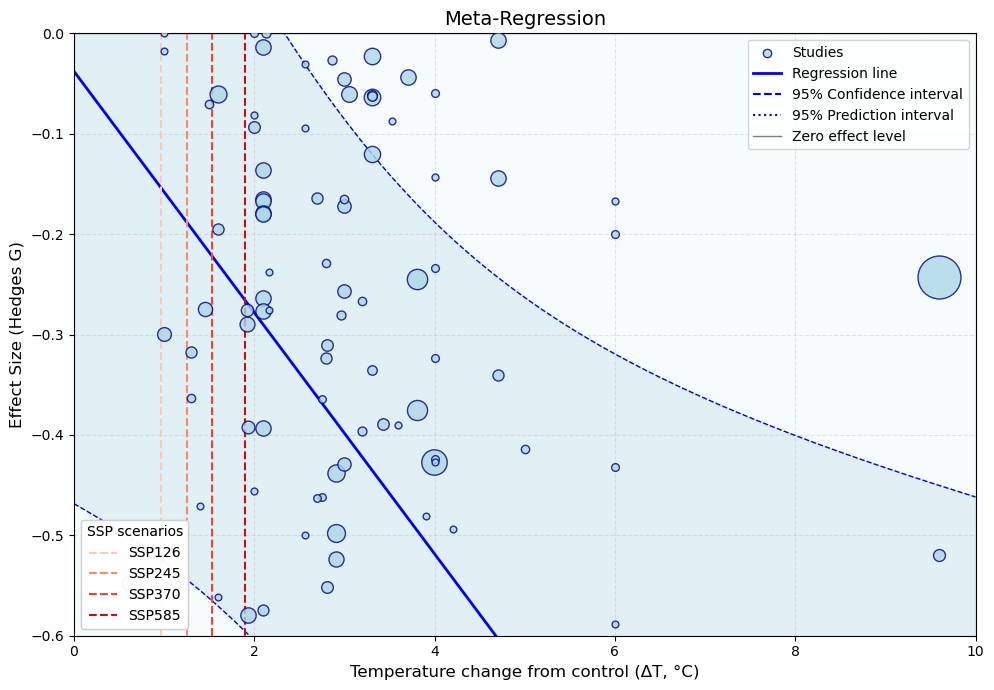

In [ ]:
fig, ax = plotting.meta_regplot(model, mod_pos=0,
                      point_size="seinv", 
                      point_color='navy',
                      point_fill='lightblue',
                      ci=True,
                      refline=0,
                      shade=True,
                      ci_color='lightblue',
                      title="Meta-Regression",
                      xlim = (0, 10),
                      predlim = (0, 10),
                      xlab = "pH change from control (ΔpH)" if x_var == "delta_ph" else "Temperature change from control (ΔT, °C)",
                      ylab=f"Effect Size ({effect_type.replace('_', ' ').title()})",)

### annotate with future climatology
df = effects_clim_df
variable = x_var

scenarios = df['scenario'].unique()
colors = sns.color_palette("Reds", len(scenarios))
scenario_var = 'ph' if 'ph' in variable else 'sst'
scenario_lines = []
for i, scenario in enumerate(scenarios):
    scenario_df = df[df['scenario'] == scenario]
    line = ax.vlines(
        x=scenario_df[f'mean_{scenario_var}_20y_anomaly_ensemble'].mean(), 
        ymin=working_df[effect_type].min()*1.1, 
        ymax=working_df[effect_type].max()*1.1, 
        color=colors[i],
        linestyle='--', 
        label=scenario.upper(), 
        # zorder=10
    )
    scenario_lines.append(line)
ax.set_ylim(
    working_df[effect_type].min()*1.1, 
    working_df[effect_type].max()*1.1
)

# get existing legend
legend1 = ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_ylim(-0.6,0)

In [ ]:
ro.r('colMeans')(model_matrix)[:]

array([2.95456345, 7.82616208, 0.15824916, 0.69023569, 0.11784512,
       0.03367003])

R[write to console]: Error in predict.rma(list(b = c(-0.12016246685229, -0.305203915900049,  : 
  Dimensions of 'newmods' (1) do not the match dimensions of the model (6).



RRuntimeError: Error in predict.rma(list(b = c(-0.12016246685229, -0.305203915900049,  : 
  Dimensions of 'newmods' (1) do not the match dimensions of the model (6).


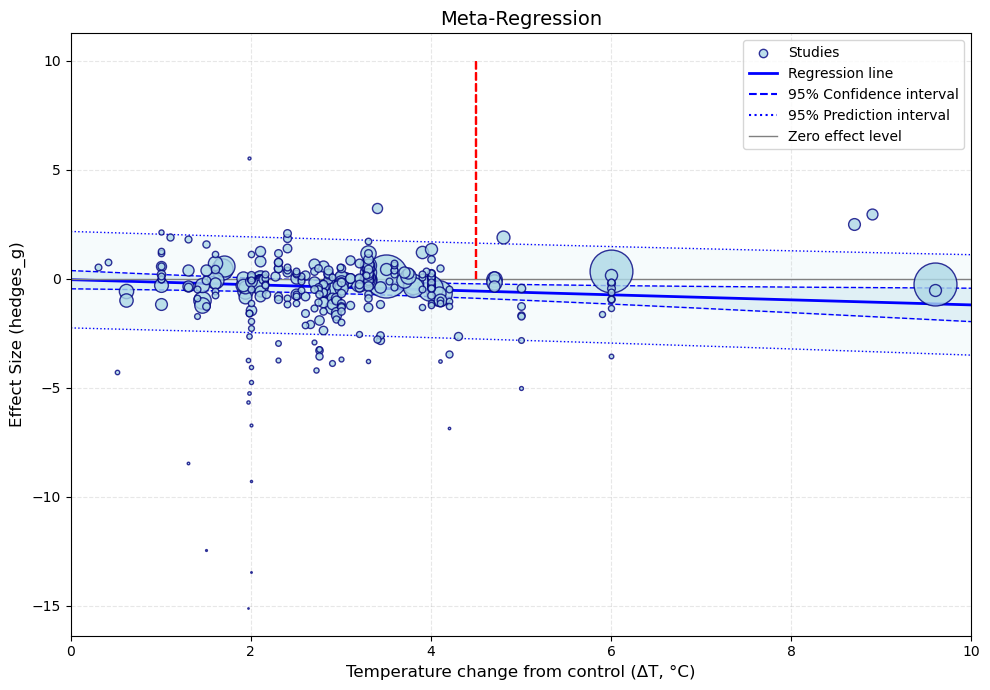

In [ ]:
# now adjust pH keeping temp constant

# Deprecated